# Fake News Detection with Artificial Intelligence
## Final Year Project - By Kishan Godhania
---

### Packages:
This first section has all the packages that are used for the project, mostly scikit learn packages with some other packages for visual graphs.

In [3]:
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

---
### Database Statistics
The first graph below shows the breakdown of the dataset before any cleaning or preprocessing has been performed on it.

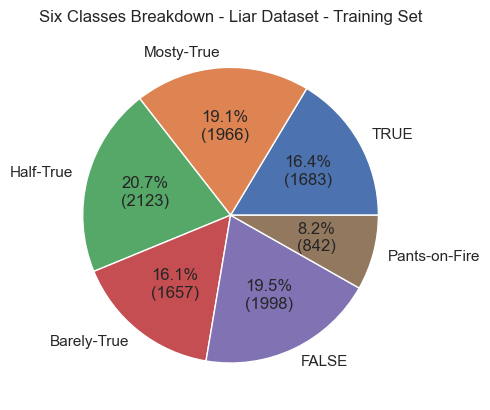

In [4]:
def databaseGraph():
    df = read_csv("Dataset/Train csv_version.csv", header = None)
    df.columns = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Occupation', 'Location','Party','Barely True Counts','False Counts','Half True Counts','Mostly True Counts','Pants on Fire Counts','Context']
    
    results = df['Label'].to_numpy()
    
    classTally = np.array([0, 0, 0, 0, 0, 0,])
    mylabels = ["TRUE", "Mosty-True","Half-True","Barely-True","FALSE","Pants-on-Fire"]

    for i in range(0,len(results)):
        if results[i] == "TRUE":
            classTally[0] += 1
        elif results[i] == "mostly-true":
            classTally[1] += 1
        elif results[i] == "half-true":
            classTally[2] += 1
        elif results[i] == "barely-true":
            classTally[3] += 1
        elif results[i] == "FALSE":
            classTally[4] += 1
        elif results[i] == "pants-fire":
            classTally[5] += 1
    
    plt.pie(classTally, labels = mylabels, autopct=lambda pct: func(pct, classTally))
    plt.title("Six Classes Breakdown - Liar Dataset - Training Set")
    plt.show()
    
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"
    
databaseGraph()

---
### Dataset Preprocessing - Cleaning
Then the cleaning process is performed on the dataset which includes the following:
- removing unnecessary columns
- removing missing records
- removing dupicate records
- concatinating the data together
- seperating the feature data and the class data
- dropping records that were assigned the "Half-True" class
- converting the remaining 5 classes into 2 classes

The graph shows the records for the new cleaned up dataset:

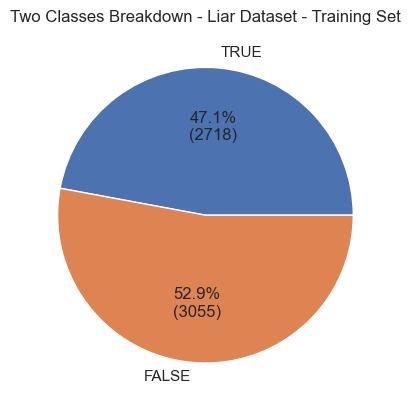

In [5]:
#Dataset Cleaning Method
def datasetPrep(dataset):
    #pulls data from csv
    df = read_csv(dataset, header=None)
    
    #add labels to all the columnns 
    df.columns = ['ID', 
                'Label',
                'Statement',
                'Subject',
                'Speaker',
                'Occupation',
                'Location',
                'Party',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts',
                'Context']
    
    #drops columns that are not helpful.
    df = df.drop(['Location',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts'], axis=1)
    
    #drops rows that have been labeled "half-true"
    df = df.drop(df[df['Label'] == 'half-true'].index)

    #drops rows with information missing in columns
    df = df.dropna()
    
    #drops rows with duplicates 
    df = df.drop_duplicates()  
    
    # combines all the different text information into one string.
    df['Combined Data'] = df['Statement'] + '\n' + df['Subject'] + '\n' + df['Speaker'] + '\n' + df['Party'] + '\n' + df['Occupation'] + '\n' + df['Context']
    
    X = df['Combined Data']
    
    Y = df['Label']
    
    #X = X.astype(str)
    Y = TwoClassConversion(Y)
    #print(X[0])

    return X, Y

# Class Conversion Method
def TwoClassConversion(outputs):
    outputs = outputs.replace(["barely-true","pants-fire"], "FALSE")
    outputs = outputs.replace(["mostly-true"], "TRUE")
    return outputs

# Graph Display Method
def cleanedDatasetGraph(Y):
    results = Y.to_numpy()
    
    classTally = np.array([0, 0,])
    mylabels = ["TRUE", "FALSE"]

    for i in range(0,len(results)):
        if results[i] == "TRUE":
            classTally[0] += 1
        elif results[i] == "FALSE":
            classTally[1] += 1
    
    plt.pie(classTally, labels = mylabels, autopct=lambda pct: func(pct, classTally))
    plt.title("Two Classes Breakdown - Liar Dataset - Training Set")
    plt.show()
    
X, Y = datasetPrep("Dataset/Train csv_version.csv")
cleanedDatasetGraph(Y)

### Dataset Preprocessing - Feature Extraction
The next coding sections extracts the features and transforms the data so that it can be used to train the machine learning models later.

In [6]:
def featureVectorizing(x,xTest,xValid):
   
    # setup count vectorizer and tfidf transformer
    count_vect = CountVectorizer()
    tfTransformer = TfidfTransformer()
    
    # feature extraction of training set
    xTrainCounts = count_vect.fit_transform(x)
    xTrainTF = tfTransformer.fit_transform(xTrainCounts)
    
    # feature extraction of testing set
    xTestCounts = count_vect.transform(xTest)
    xTestTF = tfTransformer.transform(xTestCounts)
    
    # feature extraction of validation set
    xValidCounts = count_vect.transform(xValid)
    xValidTF = tfTransformer.transform(xValidCounts)
    
    # converting feature extracted data strucutures into arrays
    xTrainTF = xTrainTF.toarray()
    xTestTF = xTestTF.toarray()
    xValidTF = xValidTF.toarray()
    
    return xTrainTF, xTestTF, xValidTF
    

In [7]:
def getData():
    # retrieve dataset from csv files
    trainDataset = "Dataset/Train csv_version.csv"
    testDataset = "Dataset/Test csv_version.csv"
    validDataset = "Dataset/Valid csv_version.csv"
    
    # apply data preprocessing to dataset
    x,y = datasetPrep(trainDataset)
    xT, yT = datasetPrep(testDataset)
    xV, yV = datasetPrep(validDataset)

    return x,y,xT,yT,xV,yV
    

### Testing Model - Performance
The method below test the model's performance using the test dataset.

It then returns the performance metrics of the model and creates a heatmap of the confusion matrix.

In [8]:
def testModel(model, data, output):
    predicted = model.predict(data)
    print(classification_report(output, predicted))
    labels = ["False", "True"]
    conMat = confusion_matrix(output, predicted)
    conHeatMap = sns.heatmap(conMat.T, square = True, annot = True, fmt = 'd', xticklabels = labels, yticklabels = labels)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

### Pipelines - Models
These are the different pipelines for the models.

Combining the Feature Extraction with the training of the models all into one method.

This then allows for hyperparameter tuning using GridSearchCV later on.

In [9]:
def nbPipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
])
    return pipeline

In [10]:
def svmPipeline():
        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(random_state=42))
])
        return pipeline

In [11]:
def decisionTreePipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier(random_state=42))
    ])
    return pipeline


In [12]:
def randomForestPipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    return pipeline

In [13]:
def xgBoostPipeline():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42))
    ])
    return pipeline
    

In [14]:
def parameterTuning(model, x, y, parameters): 
    gsModel = GridSearchCV(model, parameters, cv=10, n_jobs=-1)
    gsModel.fit(x, y)
    return gsModel


### SMOTE Pipelines
New Pipelines had to be implemented to accomodate SMOTE

These pipelines are identical in every other way to the other ones above besides that fact that they have SMOTE in the structure. 

This allows for these models to also have hyperparameter tuning like the other ones above.

In [15]:
def nbSmote():
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('SMOTE', SMOTE(random_state=42)),
        ('clf', MultinomialNB())
])
    return pipeline

In [16]:
def svmSmote():
        pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', SVC(random_state=42))
])
        return pipeline

In [17]:
def decisionTreeSmote():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', DecisionTreeClassifier(random_state=42))
    ])
    return pipeline


In [18]:
def randomForestSmote():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    return pipeline

In [19]:
def xgBoostSmote():
    pipeline = pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('smote', SMOTE(random_state=42)),
        ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42))
    ])
    return pipeline
    

### Running all the models
The following functions runs all of the models and provides the performance metrics and the heatmap from the method above. 

In [20]:
def runPipeline(modelName, modelPipeline, hypParam, smotePipeline):
    print(modelName)
    x,y,xT,yT,xV,yV = getData()
    model = modelPipeline()
    model.fit(x,y)
    testModel(model, xT, yT)
    
    print(modelName + " with Hyperparameter Tuning")
    modelTuned = parameterTuning(model, xV, yV, hypParam)
    testModel(modelTuned, xT, yT)
    
    print(modelName + " with Hyperparameter Tuning and SMOTE")
    modelSmote = smotePipeline()
    modelSmote = modelSmote.fit(x,y)
    smoteTuned = parameterTuning(modelSmote, xV, yV, hypParam)
    testModel(smoteTuned, xT, yT)


Multinomial Naive Bayes
              precision    recall  f1-score   support

       FALSE       0.62      0.74      0.68       389
        TRUE       0.64      0.50      0.56       353

    accuracy                           0.63       742
   macro avg       0.63      0.62      0.62       742
weighted avg       0.63      0.63      0.62       742



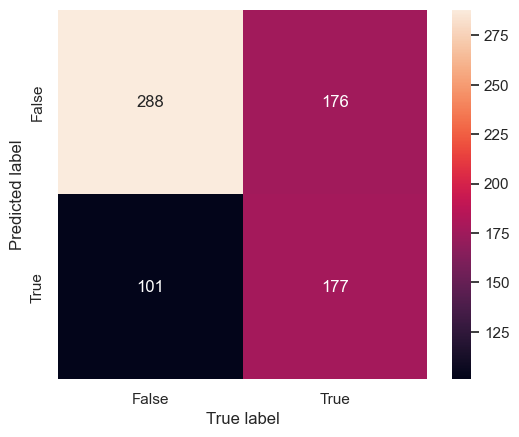

Multinomial Naive Bayes with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.59      0.65      0.62       389
        TRUE       0.57      0.51      0.54       353

    accuracy                           0.58       742
   macro avg       0.58      0.58      0.58       742
weighted avg       0.58      0.58      0.58       742



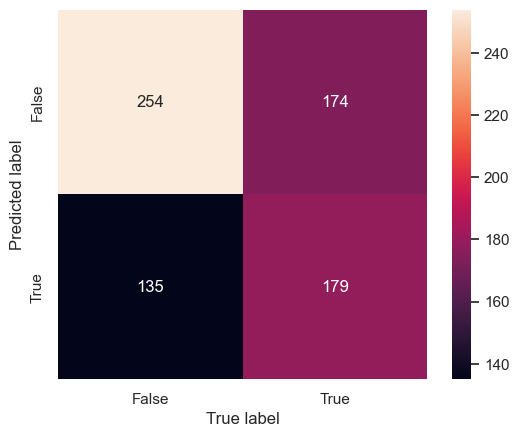

Multinomial Naive Bayes with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.59      0.61      0.60       389
        TRUE       0.55      0.52      0.54       353

    accuracy                           0.57       742
   macro avg       0.57      0.57      0.57       742
weighted avg       0.57      0.57      0.57       742



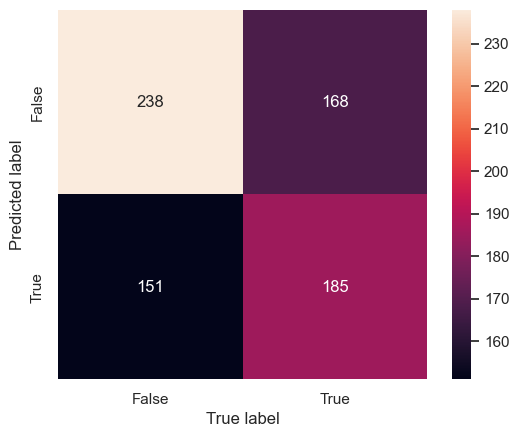

Support Vector Machine
              precision    recall  f1-score   support

       FALSE       0.65      0.68      0.67       389
        TRUE       0.63      0.60      0.62       353

    accuracy                           0.64       742
   macro avg       0.64      0.64      0.64       742
weighted avg       0.64      0.64      0.64       742



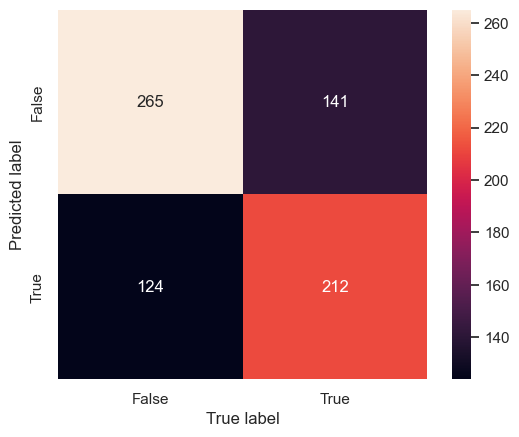

Support Vector Machine with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.60      0.68      0.63       389
        TRUE       0.58      0.50      0.54       353

    accuracy                           0.59       742
   macro avg       0.59      0.59      0.59       742
weighted avg       0.59      0.59      0.59       742



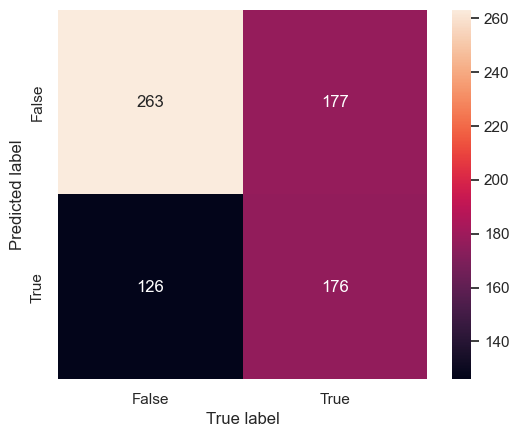

Support Vector Machine with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.59      0.66      0.62       389
        TRUE       0.57      0.50      0.53       353

    accuracy                           0.58       742
   macro avg       0.58      0.58      0.57       742
weighted avg       0.58      0.58      0.58       742



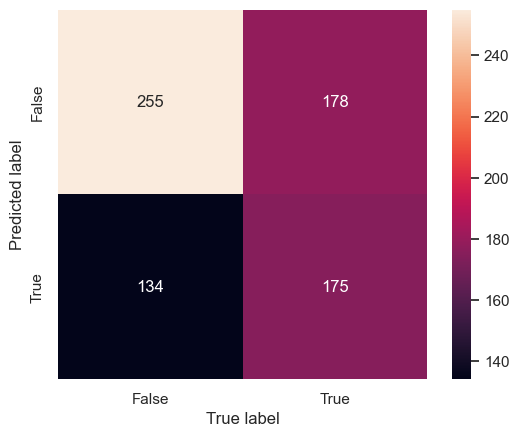

Decision Tree
              precision    recall  f1-score   support

       FALSE       0.58      0.56      0.57       389
        TRUE       0.53      0.55      0.54       353

    accuracy                           0.56       742
   macro avg       0.55      0.55      0.55       742
weighted avg       0.56      0.56      0.56       742



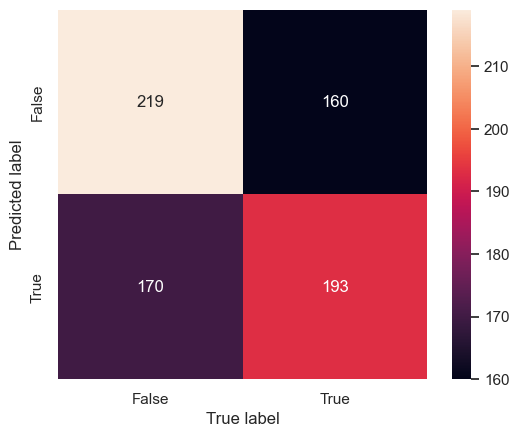

Decision Tree with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.53      0.94      0.68       389
        TRUE       0.57      0.09      0.16       353

    accuracy                           0.54       742
   macro avg       0.55      0.51      0.42       742
weighted avg       0.55      0.54      0.43       742



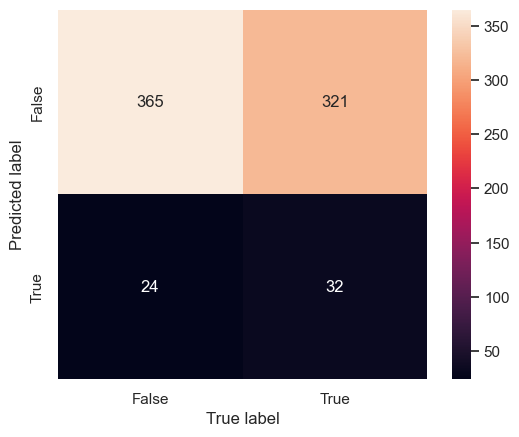

Decision Tree with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.59      0.68      0.63       389
        TRUE       0.58      0.48      0.53       353

    accuracy                           0.59       742
   macro avg       0.59      0.58      0.58       742
weighted avg       0.59      0.59      0.58       742



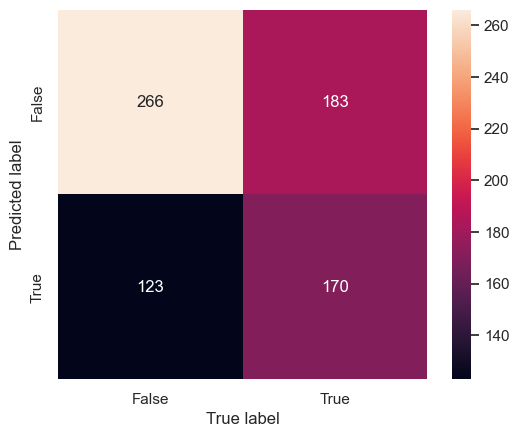

Random Forest
              precision    recall  f1-score   support

       FALSE       0.63      0.70      0.66       389
        TRUE       0.62      0.55      0.58       353

    accuracy                           0.63       742
   macro avg       0.63      0.62      0.62       742
weighted avg       0.63      0.63      0.63       742



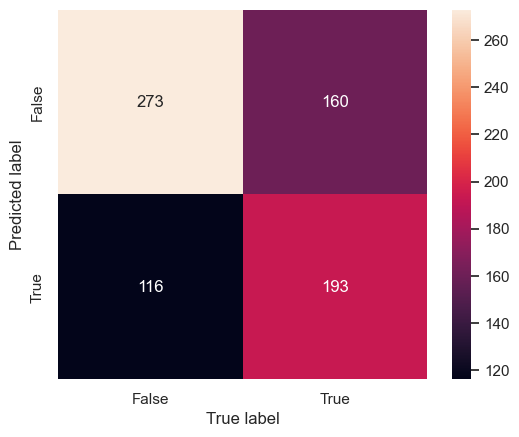

Random Forest with Hyperparameter Tuning
              precision    recall  f1-score   support

       FALSE       0.55      0.90      0.68       389
        TRUE       0.62      0.18      0.27       353

    accuracy                           0.56       742
   macro avg       0.58      0.54      0.48       742
weighted avg       0.58      0.56      0.49       742



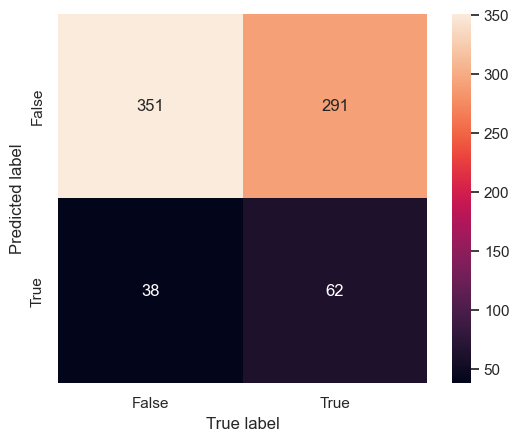

Random Forest with Hyperparameter Tuning and SMOTE
              precision    recall  f1-score   support

       FALSE       0.57      0.80      0.67       389
        TRUE       0.61      0.34      0.44       353

    accuracy                           0.58       742
   macro avg       0.59      0.57      0.55       742
weighted avg       0.59      0.58      0.56       742



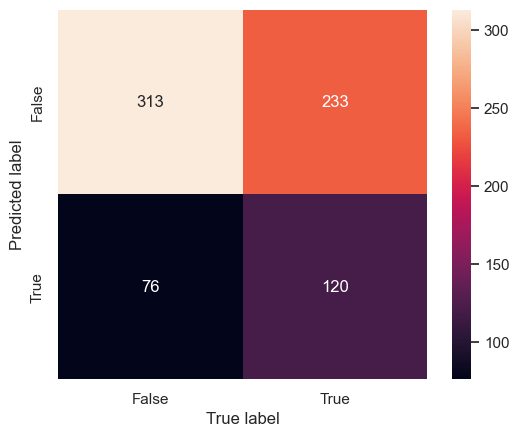


XGBoost
              precision    recall  f1-score   support

       FALSE       0.63      0.65      0.64       389
        TRUE       0.60      0.57      0.59       353

    accuracy                           0.61       742
   macro avg       0.61      0.61      0.61       742
weighted avg       0.61      0.61      0.61       742



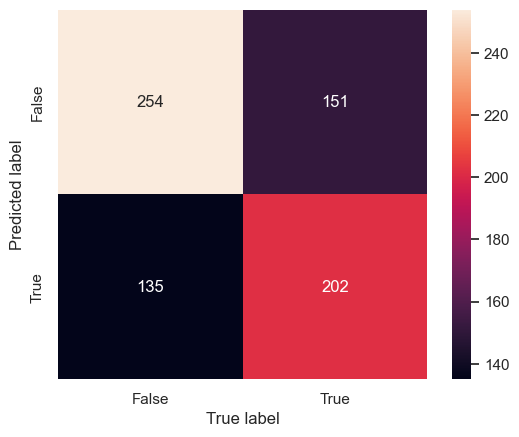

In [21]:
def runAll():
    mnbParameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        "tfidf__norm": ("l1", "l2"), # maybe remove this
        'clf__alpha': (1e-2, 1e-3)
    }
        
    SvmSvcParameters = {        
        "vect__ngram_range": ((1, 1), (1, 2)),
        "tfidf__use_idf": (True, False),
        "tfidf__norm": ("l1", "l2"),
        'clf__C': (0.1, 1, 10, 100),
        'clf__gamma': (0.01, 0.1, 1, 10),
        'clf__kernel': ('rbf', 'linear', 'poly')}
    
    decTreeParam = {
        "vect__ngram_range": ((1, 1), (1, 2)),
        "tfidf__use_idf": (True, False),
        "tfidf__norm": ("l1", "l2"),
        "clf__max_depth": (np.arange(2, 10, 1))
    }
    
    randForestParam = {
        "vect__ngram_range": ((1, 1), (1, 2)),
        "tfidf__use_idf": (True, False),
        "tfidf__norm": ("l1", "l2"),
        "clf__max_features": (1, 5),
        "clf__n_estimators": (10, 100, 1000)
    }
    
    runPipeline("Multinomial Naive Bayes", nbPipeline, mnbParameters, nbSmote)
    runPipeline("Support Vector Machine", svmPipeline, SvmSvcParameters, svmSmote)
    runPipeline("Decision Tree", decisionTreePipeline, decTreeParam, decisionTreeSmote)
    runPipeline("Random Forest", randomForestPipeline, randForestParam, randomForestSmote)
    
    x,y,xT,yT,xV,yV = getData()    
    print()
    print("XGBoost")
    xgBoostModel = xgBoostPipeline()
    xgBoostModel = xgBoostModel.fit(x,y)
    testModel(xgBoostModel, xT, yT)

runAll()